<a href="https://colab.research.google.com/github/skitw427/Layerwise-XAI/blob/main/notebook_demo/ResNet18_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import timm
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import ast
import os

In [ ]:
model_name = "resnet18.a1_in1k"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = timm.create_model(model_name, pretrained=True)
model.eval()
model = model.to(device)

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def get_pil_transform():
    transf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=mean,std=std)
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

image_dir = 'cat/'

images = []
for filename in os.listdir(image_dir):
    if filename.endswith('.JPEG'):
        image_path = os.path.join(image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        images.append(image)



def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

test_pred = batch_predict([pill_transf(image) for image in images])
for i, pred in enumerate(test_pred):
    print(f"prediction index for image {i}: {pred.argmax()}")

for i, pred in enumerate(test_pred):
    top5_indices = np.argsort(pred)[-5:][::-1]
    print(f"Top 5 prediction indices for image {i}: {top5_indices}")

prediction index for image 0: 283
prediction index for image 1: 283
prediction index for image 2: 283
prediction index for image 3: 283
prediction index for image 4: 283
prediction index for image 5: 281
prediction index for image 6: 283
prediction index for image 7: 230
Top 5 prediction indices for image 0: [283 259 332 152 157]
Top 5 prediction indices for image 1: [283 287 918 422 722]
Top 5 prediction indices for image 2: [283 287 259 261 332]
Top 5 prediction indices for image 3: [283 152 156 154 332]
Top 5 prediction indices for image 4: [283 918 543 287 284]
Top 5 prediction indices for image 5: [281 287 285 282 283]
Top 5 prediction indices for image 6: [283 760 761 457 478]
Top 5 prediction indices for image 7: [230 232 283 231 700]


In [ ]:
from lime import lime_image

img = images[0]

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(#np.array([pill_transf(image) for image in images]),
                                         np.array(pill_transf(img)),
                                         batch_predict, # classification function
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=5000) # number of images that will be sent to classification function

  0%|          | 0/5000 [00:00<?, ?it/s]

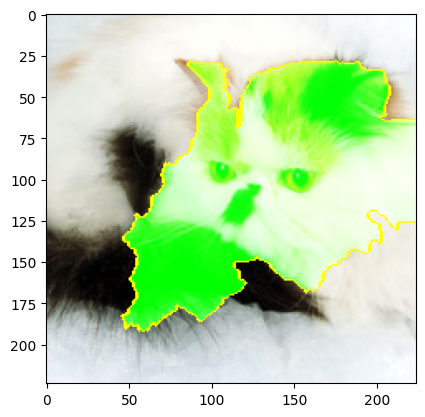

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Explaining image 1/8


  0%|          | 0/5000 [00:00<?, ?it/s]

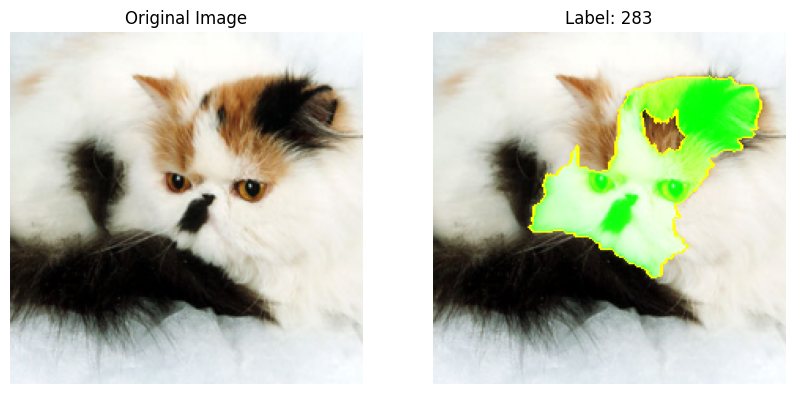

Explaining image 2/8


  0%|          | 0/5000 [00:00<?, ?it/s]

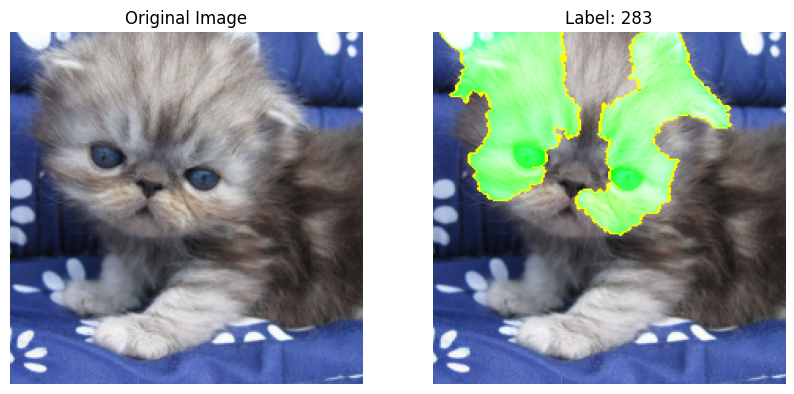

Explaining image 3/8


  0%|          | 0/5000 [00:00<?, ?it/s]

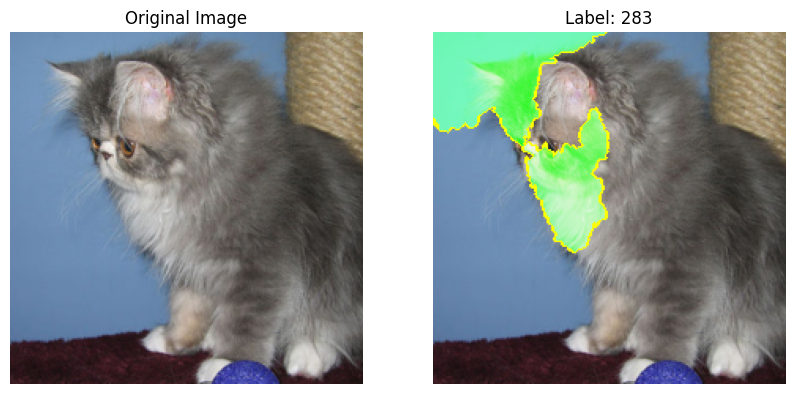

Explaining image 4/8


  0%|          | 0/5000 [00:00<?, ?it/s]

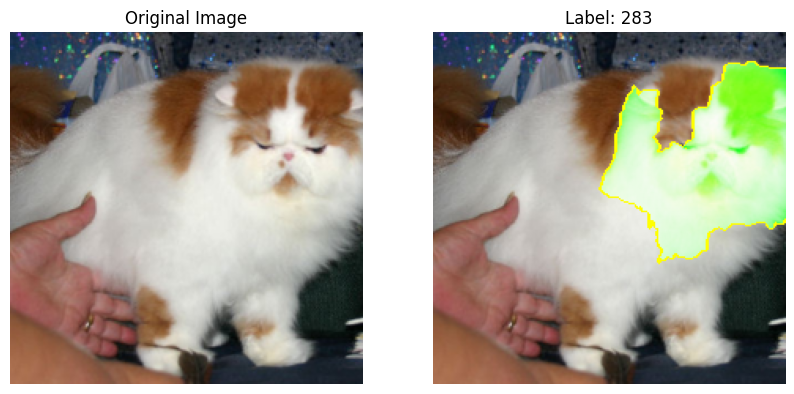

Explaining image 5/8


  0%|          | 0/5000 [00:00<?, ?it/s]

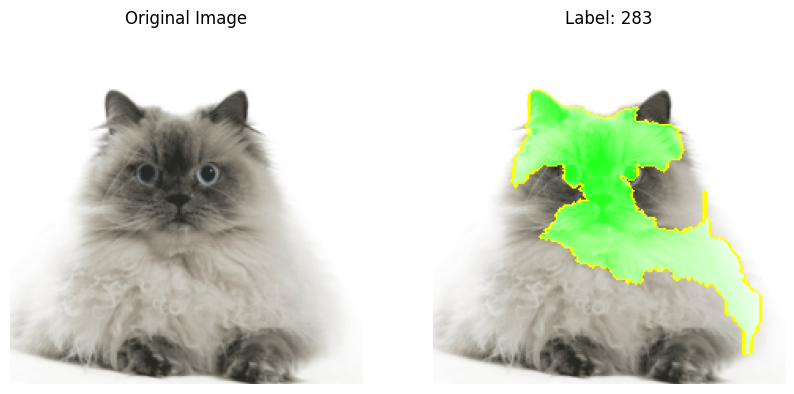

Explaining image 6/8


  0%|          | 0/5000 [00:00<?, ?it/s]

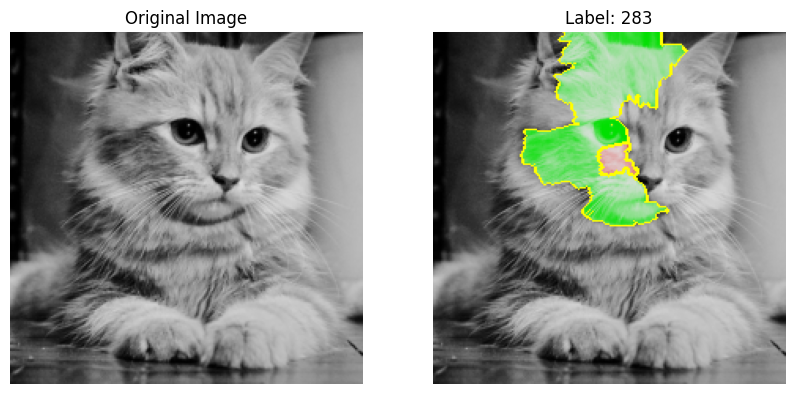

Explaining image 7/8


  0%|          | 0/5000 [00:00<?, ?it/s]

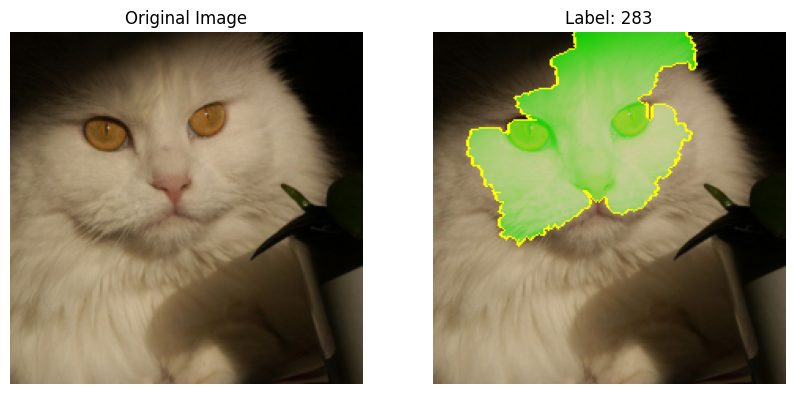

Explaining image 8/8


  0%|          | 0/5000 [00:00<?, ?it/s]

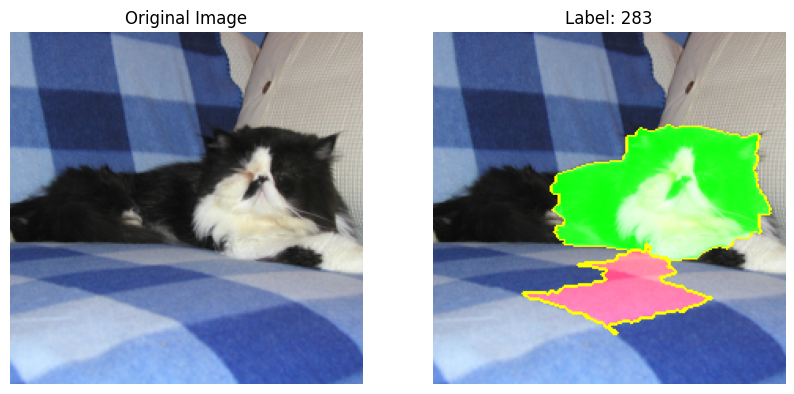

In [ ]:
explainer = lime_image.LimeImageExplainer()

label = 283

for i, img in enumerate(images):
    print(f"Explaining image {i+1}/{len(images)}")

    transf_img = pill_transf(img)

    explanation = explainer.explain_instance(
        np.array(pill_transf(img)),  # 설명할 이미지
        batch_predict,               # 분류 함수
        #top_labels=5,
        labels=[label],
        hide_color=0,
        num_samples=5000
    )

    #top_label = explanation.top_labels[0]

    temp, mask = explanation.get_image_and_mask(
        #top_label,
        label,
        positive_only=False,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(transf_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp/255.0, mask))
    plt.title(f"Label: {label}")
    plt.axis('off')

    plt.show()


    #plt.title(f"Image {i+1} - Top Label: {top_label}")
    #plt.imshow(temp)
    #plt.axis('off')
    #plt.show()